In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/secondary-protein-structure-prediction/synthetic_data.csv
/kaggle/input/secondary-protein-structure-prediction/real_predictions.csv
/kaggle/input/secondary-protein-structure-prediction/combined_data.csv


In [53]:
def setup_gpu():
    if torch.cuda.is_available():
        print(f"GPU available: {torch.cuda.get_device_name(0)}")
        print(f"Number of GPUs: {torch.cuda.device_count()}")
        
        device = torch.device("cuda")
        
        torch.backends.cudnn.benchmark = True  
        torch.backends.cudnn.deterministic = False 
        
        torch.cuda.empty_cache()
        
        if torch.cuda.device_count() > 1:
            print(f"Using {torch.cuda.device_count()} GPUs")
    else:
        device = torch.device("cpu")
        print("No GPU available, using CPU")
    
    return device

device = setup_gpu()

GPU available: Tesla T4
Number of GPUs: 2
Using 2 GPUs


In [54]:
class ProteinSecondaryStructureDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.data_files = self._get_data_files()
        
    def _get_data_files(self):
        files = [os.path.join(self.data_path, f) for f in os.listdir(self.data_path) 
                if f.endswith('.npy') or f.endswith('.npz')]
        return files
        
    def __len__(self):
        return len(self.data_files)
        
    def __getitem__(self, idx):
        structure = np.load(self.data_files[idx])
        
        if self.transform:
            structure = self.transform(structure)
            
        return torch.tensor(structure, dtype=torch.float32)

def create_data_loaders(data_path, batch_size=128, num_workers=4, pin_memory=True):
    dataset = ProteinSecondaryStructureDataset(data_path)
    
    data_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory,  
        persistent_workers=(num_workers > 0),  
        prefetch_factor=2 if num_workers > 0 else None,  
    )
    
    return data_loader

def create_synthetic_dataset(output_dir, num_samples=1000, input_dim=400):
    os.makedirs(output_dir, exist_ok=True)
    
    for i in range(num_samples):
        structure = np.random.rand(input_dim).astype(np.float32)
        
        np.save(os.path.join(output_dir, f"protein_{i}.npy"), structure)
    
    print(f"Created {num_samples} synthetic protein structures in {output_dir}")

In [55]:
class ProteinVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, dropout_rate=0.1):
        super(ProteinVAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate)
        )
        
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, input_dim)  
        )
        
    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        log_var = self.fc_var(h)
        return mu, log_var
        
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
        
    def decode(self, z):
        return self.decoder(z) 
        
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconstructed = self.decode(z)  
        return x_reconstructed, mu, log_var

In [56]:
def vae_loss_function(recon_x, x, mu, log_var, beta=1.0):
    BCE = F.binary_cross_entropy_with_logits(recon_x, x, reduction='sum')
    
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    return BCE + beta * KLD

class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, save_path='best_model.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.save_path = save_path
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(model)
            self.counter = 0
    
    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.save_path)
        print(f'Model saved to {self.save_path}')

In [57]:
def train_model(model, train_loader, val_loader, device, epochs=100, lr=1e-3, 
                beta=1.0, weight_decay=1e-5, use_amp=True):
    optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=lr, 
        weight_decay=weight_decay
    )
    
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=epochs, eta_min=lr/10
    )
    
    early_stopping = EarlyStopping(patience=10, save_path='best_vae_model.pt')
    
    scaler = GradScaler() if use_amp else None
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        
        for batch_idx, data in enumerate(progress_bar):
            data = data.to(device, non_blocking=True)
            optimizer.zero_grad()
            
            if use_amp:
                with autocast(device_type='cuda'):
                    recon_batch, mu, log_var = model(data)
                    loss = vae_loss_function(recon_batch, data, mu, log_var, beta=beta)
                
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                recon_batch, mu, log_var = model(data)
                loss = vae_loss_function(recon_batch, data, mu, log_var, beta=beta)
                loss.backward()
                optimizer.step()
            
            train_loss += loss.item()
            
            progress_bar.set_postfix({'loss': loss.item()})
            
            del data, recon_batch, mu, log_var, loss
        
        scheduler.step()
        
        avg_train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)
        
        model.eval()
        val_loss = 0
        
        with torch.no_grad():
            for data in val_loader:
                data = data.to(device, non_blocking=True)
                
                if use_amp:
                    with autocast(device_type='cuda'):  
                        recon_batch, mu, log_var = model(data)
                        loss = vae_loss_function(recon_batch, data, mu, log_var, beta=beta)
                else:
                    recon_batch, mu, log_var = model(data)
                    loss = vae_loss_function(recon_batch, data, mu, log_var, beta=beta)
                
                val_loss += loss.item()
                
                del data, recon_batch, mu, log_var, loss
        
        avg_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)
        
        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch+1}")
            break
        
        print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        torch.cuda.empty_cache()
        gc.collect()
    
    model.load_state_dict(torch.load('best_vae_model.pt'))
    
    return model, train_losses, val_losses                

In [58]:
@torch.no_grad()
def evaluate_model(model, test_loader, device, use_amp=True):
    model.eval()
    test_loss = 0
    reconstruction_error = 0
    kl_divergence = 0
    
    all_mu = []
    all_log_var = []
    
    with torch.no_grad():
        for data in tqdm(test_loader, desc="Evaluating"):
            data = data.to(device, non_blocking=True)
            
            if use_amp:
                with autocast(device_type='cuda'): 
                    recon_batch, mu, log_var = model(data)
                    loss = vae_loss_function(recon_batch, data, mu, log_var)
            else:
                recon_batch, mu, log_var = model(data)
                loss = vae_loss_function(recon_batch, data, mu, log_var)
            
            test_loss += loss.item()
            
            recon_error = F.binary_cross_entropy_with_logits(recon_batch, data, reduction='sum').item()
            reconstruction_error += recon_error
            
            kld = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()).item()
            kl_divergence += kld
            
            all_mu.append(mu.cpu().numpy())
            all_log_var.append(log_var.cpu().numpy())
            
            del data, recon_batch, mu, log_var
            torch.cuda.empty_cache()
    
    test_loss /= len(test_loader.dataset)
    reconstruction_error /= len(test_loader.dataset)
    kl_divergence /= len(test_loader.dataset)
    
    all_mu = np.concatenate(all_mu, axis=0)
    all_log_var = np.concatenate(all_log_var, axis=0)
    
    mu_mean = np.mean(all_mu, axis=0)
    mu_std = np.std(all_mu, axis=0)
    var_mean = np.mean(np.exp(all_log_var), axis=0)
    
    metrics = {
        'test_loss': test_loss,
        'reconstruction_error': reconstruction_error,
        'kl_divergence': kl_divergence,
        'mu_mean': mu_mean,
        'mu_std': mu_std,
        'var_mean': var_mean
    }
    
    return metrics, all_mu, all_log_var

In [59]:
class ProteinVAEInferenceEngine:
    
    def __init__(self, model, device, use_amp=True):
        self.model = model
        self.device = device
        self.use_amp = use_amp
        self.model.eval()
        
        self.is_data_parallel = hasattr(self.model, 'module')
        
        self.actual_model = self.model.module if self.is_data_parallel else self.model
    
    @torch.no_grad()
    def encode(self, structure):
        if isinstance(structure, np.ndarray):
            structure = torch.tensor(structure, dtype=torch.float32)
        
        if len(structure.shape) == 1:
            structure = structure.unsqueeze(0)
        
        structure = structure.to(self.device)
        
        if self.use_amp:
            with autocast(device_type='cuda'):
                mu, log_var = self.actual_model.encode(structure)
                z = self.actual_model.reparameterize(mu, log_var)
        else:
            mu, log_var = self.actual_model.encode(structure)
            z = self.actual_model.reparameterize(mu, log_var)
        
        return z.cpu().numpy(), mu.cpu().numpy(), log_var.cpu().numpy()
    
    @torch.no_grad()
    def decode(self, z):
        if isinstance(z, np.ndarray):
            z = torch.tensor(z, dtype=torch.float32)
        
        z = z.to(self.device)
        
        if self.use_amp:
            with autocast(device_type='cuda'):
                logits = self.actual_model.decode(z)
                decoded = torch.sigmoid(logits)
        else:
            logits = self.actual_model.decode(z)
            decoded = torch.sigmoid(logits)
        
        return decoded.cpu().numpy()
    
    @torch.no_grad()
    def reconstruct(self, structure):
        if isinstance(structure, np.ndarray):
            structure = torch.tensor(structure, dtype=torch.float32)
        
        if len(structure.shape) == 1:
            structure = structure.unsqueeze(0)
        
        structure = structure.to(self.device)
        
        if self.use_amp:
            with autocast(device_type='cuda'):
                logits, _, _ = self.model(structure)
                recon = torch.sigmoid(logits)
        else:
            logits, _, _ = self.model(structure) 
            recon = torch.sigmoid(logits)
        
        return recon.cpu().numpy()

    def interpolate(self, structure1, structure2, steps=10):
        z1, _, _ = self.encode(structure1)
        z2, _, _ = self.encode(structure2)
        
        interpolations = []
        for alpha in np.linspace(0, 1, steps):
            z_interp = z1 * (1 - alpha) + z2 * alpha
            decoded = self.decode(z_interp)
            interpolations.append(decoded)
        
        return interpolations
    
    @torch.no_grad()
    def generate_novel_structures(self, n_samples=10, latent_dim=None):
        if latent_dim is None:
            for name, param in self.actual_model.named_parameters():
                if 'fc_mu.weight' in name:
                    latent_dim = param.shape[0]
                    break
        
        if latent_dim is None:
            raise ValueError("Could not infer latent dimension, please specify manually")
        
        z_samples = torch.randn(n_samples, latent_dim).to(self.device)
        
        if self.use_amp:
            with autocast(device_type='cuda'):
                logits = self.actual_model.decode(z_samples)
                novel_structures = torch.sigmoid(logits)
        else:
            logits = self.actual_model.decode(z_samples)
            novel_structures = torch.sigmoid(logits)
        
        return novel_structures.cpu().numpy()
    
    def latent_arithmetic(self, structure_a, structure_b, structure_c):
        z_a, _, _ = self.encode(structure_a)
        z_b, _, _ = self.encode(structure_b)
        z_c, _, _ = self.encode(structure_c)
        
        z_result = z_a - z_b + z_c
        
        result_structure = self.decode(z_result)
        
        return result_structure
    
    def find_nearest_neighbors(self, query_structure, reference_structures, k=5):
        query_z, _, _ = self.encode(query_structure)
        
        reference_z = []
        for structure in tqdm(reference_structures, desc="Encoding reference structures"):
            z, _, _ = self.encode(structure)
            reference_z.append(z)
        
        reference_z = np.concatenate(reference_z, axis=0)
        
        distances = np.linalg.norm(reference_z - query_z, axis=1)
        
        nearest_indices = np.argsort(distances)[:k]
        
        return nearest_indices, distances[nearest_indices]

In [60]:
def plot_reconstructions(original, reconstructed, n_samples=5):
    n_samples = min(n_samples, len(original))
    
    fig, axes = plt.subplots(n_samples, 2, figsize=(12, 3*n_samples))
    
    for i in range(n_samples):
        orig_shape = int(np.sqrt(original[i].shape[0]))
        recon_shape = int(np.sqrt(reconstructed[i].shape[0]))
        
        axes[i, 0].imshow(original[i].reshape(orig_shape, -1), cmap='viridis')
        axes[i, 0].set_title(f"Original {i+1}")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(reconstructed[i].reshape(recon_shape, -1), cmap='viridis')
        axes[i, 1].set_title(f"Reconstructed {i+1}")
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.savefig('reconstructions.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_latent_traversal(inference_engine, base_z, dim_idx, range_vals=(-3, 3), steps=10):
    traversal_values = np.linspace(range_vals[0], range_vals[1], steps)
    
    reconstructions = []
    for val in traversal_values:
        z_modified = base_z.copy()
        z_modified[0, dim_idx] = val
        
        reconstruction = inference_engine.decode(z_modified)
        reconstructions.append(reconstruction[0]) 
    
    fig, axes = plt.subplots(1, steps, figsize=(steps*2, 3))
    
    for i, (val, recon) in enumerate(zip(traversal_values, reconstructions)):
        recon_shape = int(np.sqrt(recon.shape[0]))
        
        axes[i].imshow(recon.reshape(recon_shape, -1), cmap='viridis')
        axes[i].set_title(f"z_{dim_idx}={val:.1f}")
        axes[i].axis('off')
    
    plt.suptitle(f"Latent Dimension {dim_idx} Traversal")
    plt.tight_layout()
    plt.savefig(f'latent_traversal_dim_{dim_idx}.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_interpolation(structures, steps):
    fig, axes = plt.subplots(1, steps, figsize=(steps*2, 3))
    
    for i, structure in enumerate(structures):
        struct_shape = int(np.sqrt(structure.shape[0]))
        
        axes[i].imshow(structure.reshape(struct_shape, -1), cmap='viridis')
        axes[i].set_title(f"Step {i+1}")
        axes[i].axis('off')
    
    plt.suptitle("Interpolation in Latent Space")
    plt.tight_layout()
    plt.savefig('interpolation.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_latent_heatmap(all_mu, all_log_var):
    mu_mean = np.mean(all_mu, axis=0)
    mu_std = np.std(all_mu, axis=0)
    var_mean = np.exp(np.mean(all_log_var, axis=0))
    
    fig, axes = plt.subplots(3, 1, figsize=(12, 15))
    
    sns.barplot(x=np.arange(len(mu_mean)), y=mu_mean, ax=axes[0])
    axes[0].set_title('Mean of Latent Means (μ)')
    axes[0].set_xlabel('Latent Dimension')
    axes[0].set_ylabel('Mean Value')
    
    sns.barplot(x=np.arange(len(mu_std)), y=mu_std, ax=axes[1])
    axes[1].set_title('Standard Deviation of Latent Means (μ)')
    axes[1].set_xlabel('Latent Dimension')
    axes[1].set_ylabel('Std Value')
    
    sns.barplot(x=np.arange(len(var_mean)), y=var_mean, ax=axes[2])
    axes[2].set_title('Mean of Latent Variances (σ²)')
    axes[2].set_xlabel('Latent Dimension')
    axes[2].set_ylabel('Variance Value')
    
    plt.tight_layout()
    plt.savefig('latent_statistics.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_correlation_matrix(all_mu):
    corr_matrix = np.corrcoef(all_mu.T)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, 
                fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix of Latent Dimensions')
    plt.tight_layout()
    plt.savefig('latent_correlation.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return corr_matrix

def plot_generated_structures(structures, n_samples=10):
    n_samples = min(n_samples, len(structures))
    
    fig, axes = plt.subplots(2, n_samples//2 + n_samples%2, figsize=(n_samples*2, 6))
    axes = axes.flatten()
    
    for i in range(n_samples):
        struct_shape = int(np.sqrt(structures[i].shape[0]))
        
        axes[i].imshow(structures[i].reshape(struct_shape, -1), cmap='viridis')
        axes[i].set_title(f"Generated {i+1}")
        axes[i].axis('off')
    
    plt.suptitle("Generated Protein Structures")
    plt.tight_layout()
    plt.savefig('generated_structures.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_latent_space(all_mu, labels=None, method='tsne', perplexity=30, n_components=2):
    if method.lower() == 'tsne':
        reducer = TSNE(n_components=n_components, random_state=42, 
                      perplexity=perplexity, n_jobs=-1)
        print("Applying t-SNE dimensionality reduction...")
    elif method.lower() == 'umap':
        try:
            import umap
            reducer = umap.UMAP(n_components=n_components, random_state=42)
            print("Applying UMAP dimensionality reduction...")
        except ImportError:
            print("UMAP not installed. Using PCA instead.")
            reducer = PCA(n_components=n_components)
            method = 'pca'
    else:  
        reducer = PCA(n_components=n_components)
        print("Applying PCA dimensionality reduction...")
    
    reduced_data = reducer.fit_transform(all_mu)
    
    plt.figure(figsize=(12, 10))
    
    if labels is not None:
        scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, 
                             cmap='viridis', alpha=0.7, s=10)
        plt.colorbar(scatter, label='Structure Class')
    else:
        plt.scatter(reduced_data[:, 0], reduced_data[:, 1], alpha=0.7, s=10)
    
    plt.title(f'Latent Space Visualization using {method.upper()}')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.tight_layout()
    plt.savefig(f'latent_space_{method.lower()}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return reduced_data
    

Created 1000 synthetic protein structures in /kaggle/working/protein_data/train
Created 200 synthetic protein structures in /kaggle/working/protein_data/val
Created 200 synthetic protein structures in /kaggle/working/protein_data/test
Starting training...


<ipython-input-57-639bcf3eaaf6>:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if use_amp else None


Epoch 1/10:   0%|          | 0/8 [00:00<?, ?it/s]

Model saved to best_vae_model.pt
Epoch 1: Train Loss: 291.7712, Val Loss: 278.6492


Epoch 2/10:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 2: Train Loss: 289.1974, Val Loss: 279.3876


Epoch 3/10:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 3: Train Loss: 286.4207, Val Loss: 280.2085


Epoch 4/10:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 4: Train Loss: 284.9486, Val Loss: 280.7572


Epoch 5/10:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5: Train Loss: 284.1833, Val Loss: 281.1189


Epoch 6/10:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 6: Train Loss: 283.6947, Val Loss: 281.1869


Epoch 7/10:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 7: Train Loss: 283.2390, Val Loss: 281.1482


Epoch 8/10:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 8: Train Loss: 282.9936, Val Loss: 281.0704


Epoch 9/10:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 9: Train Loss: 282.9159, Val Loss: 281.1162


Epoch 10/10:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 10: Train Loss: 282.6922, Val Loss: 281.1554


<ipython-input-57-639bcf3eaaf6>:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_vae_model.pt'))


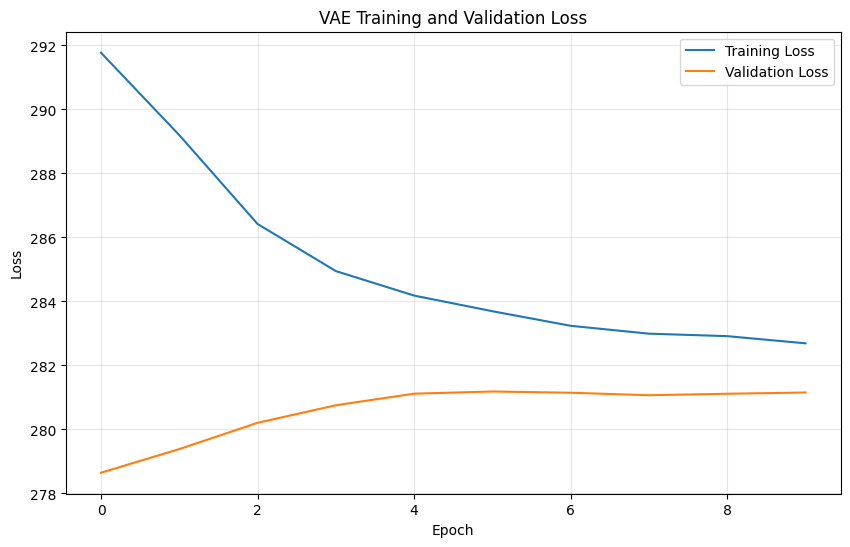

Evaluating model...


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]


Evaluation Metrics:
test_loss: 278.5146
reconstruction_error: 278.3618
kl_divergence: 0.1527
mu_mean: shape (32,)
mu_std: shape (32,)
var_mean: shape (32,)
Disentanglement score: 0.9024
Visualizing latent space...
Applying t-SNE dimensionality reduction...


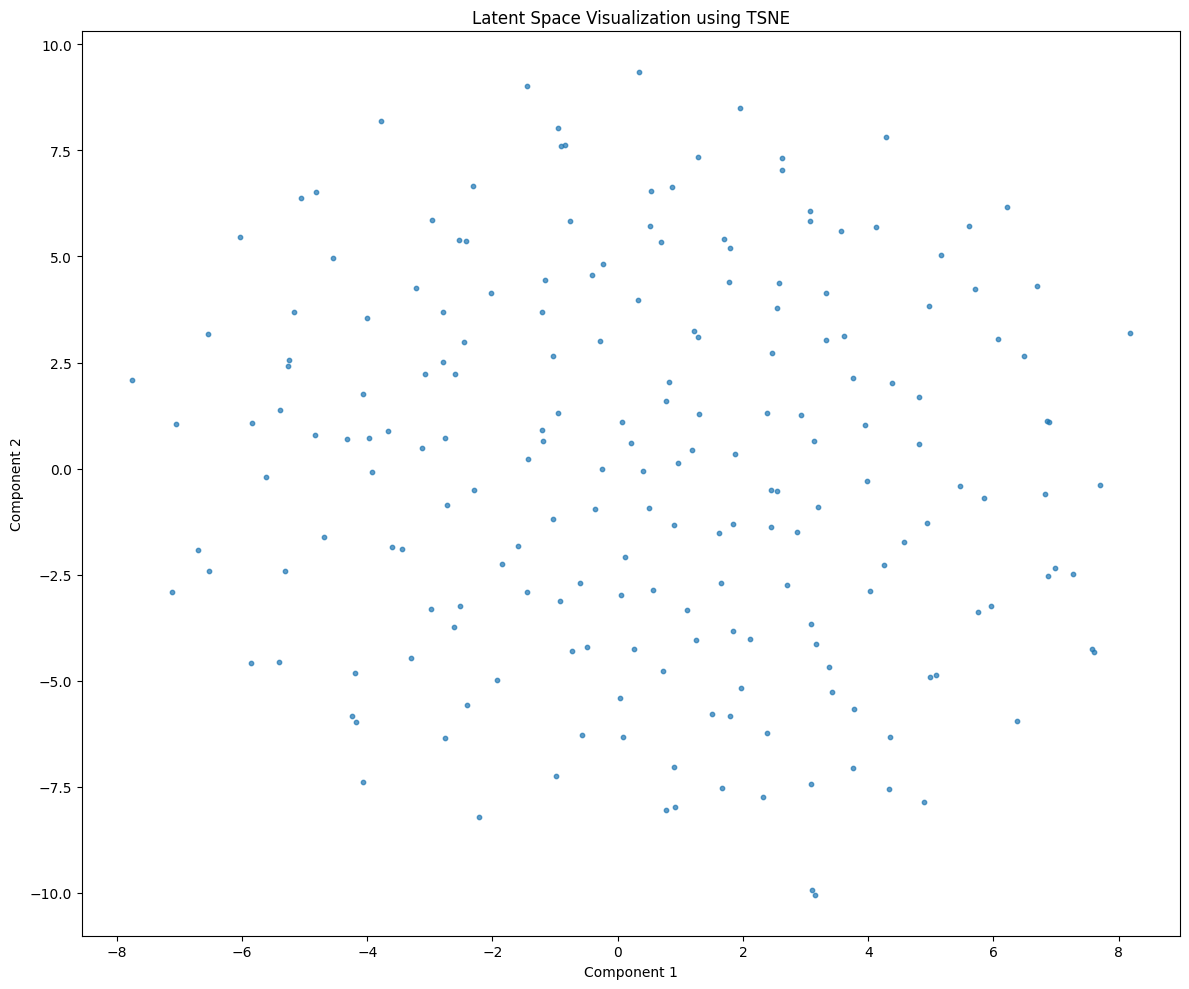

Applying PCA dimensionality reduction...


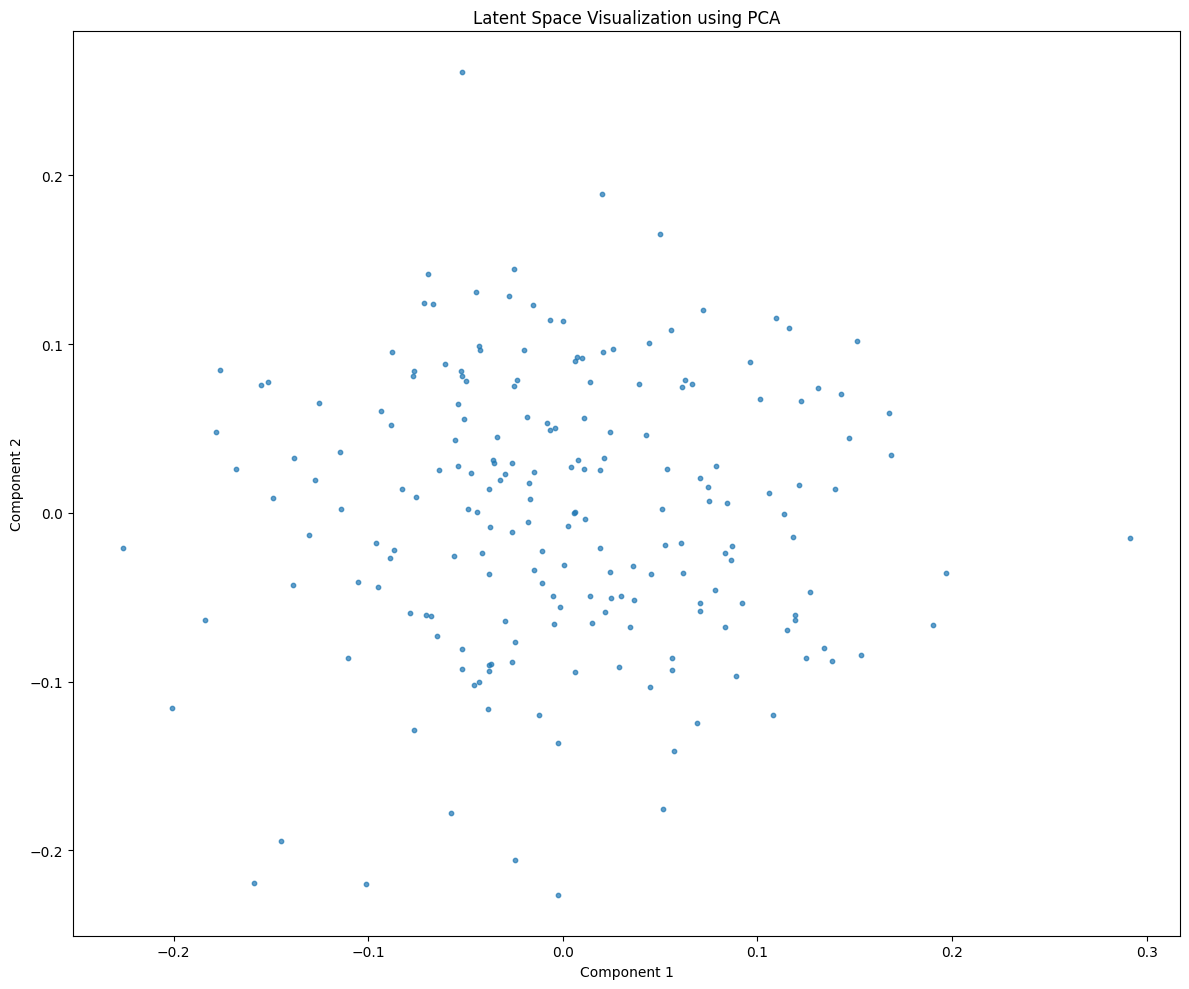

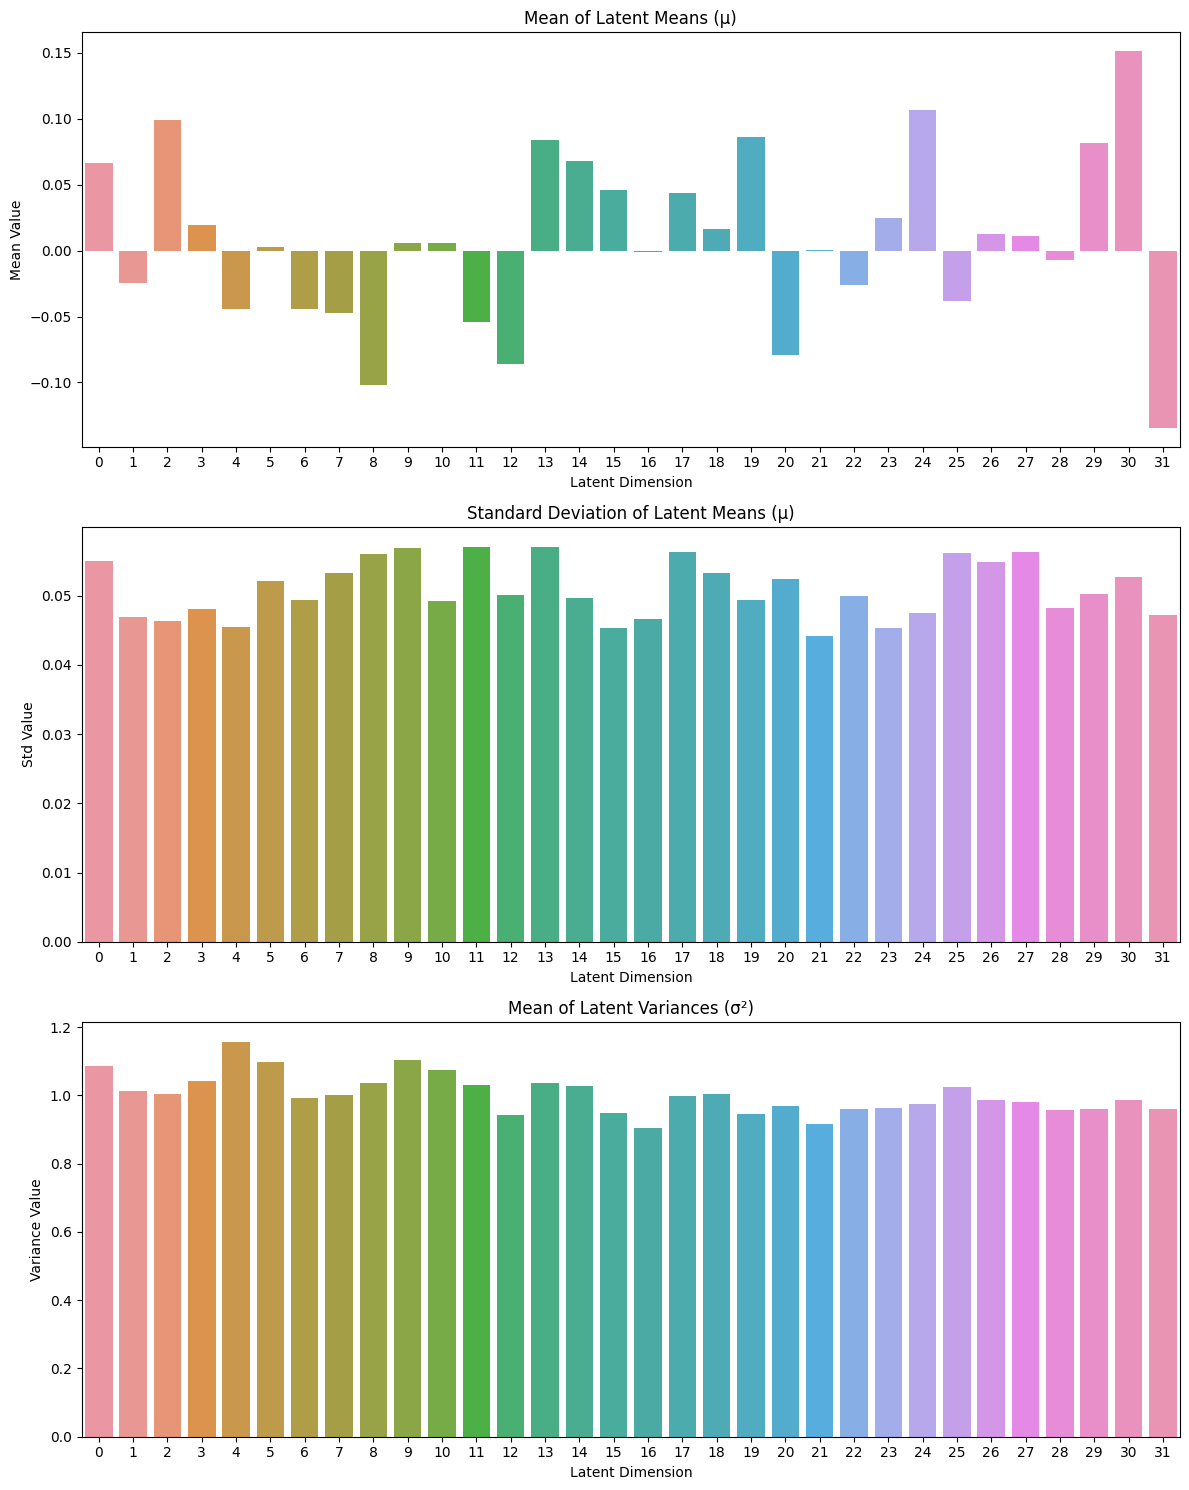

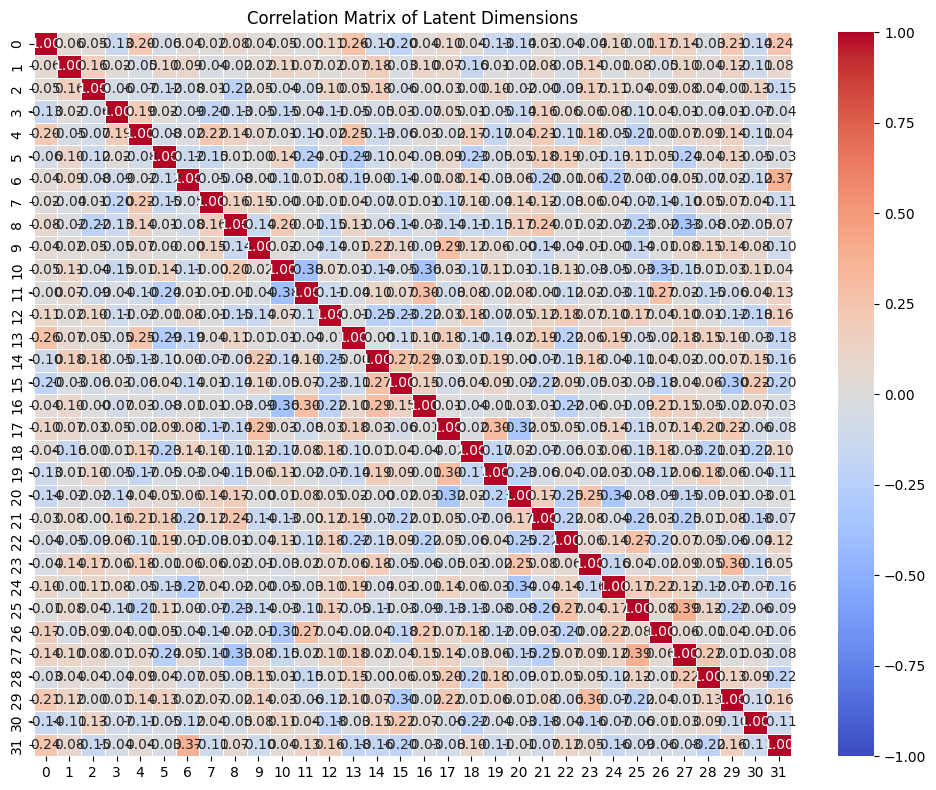

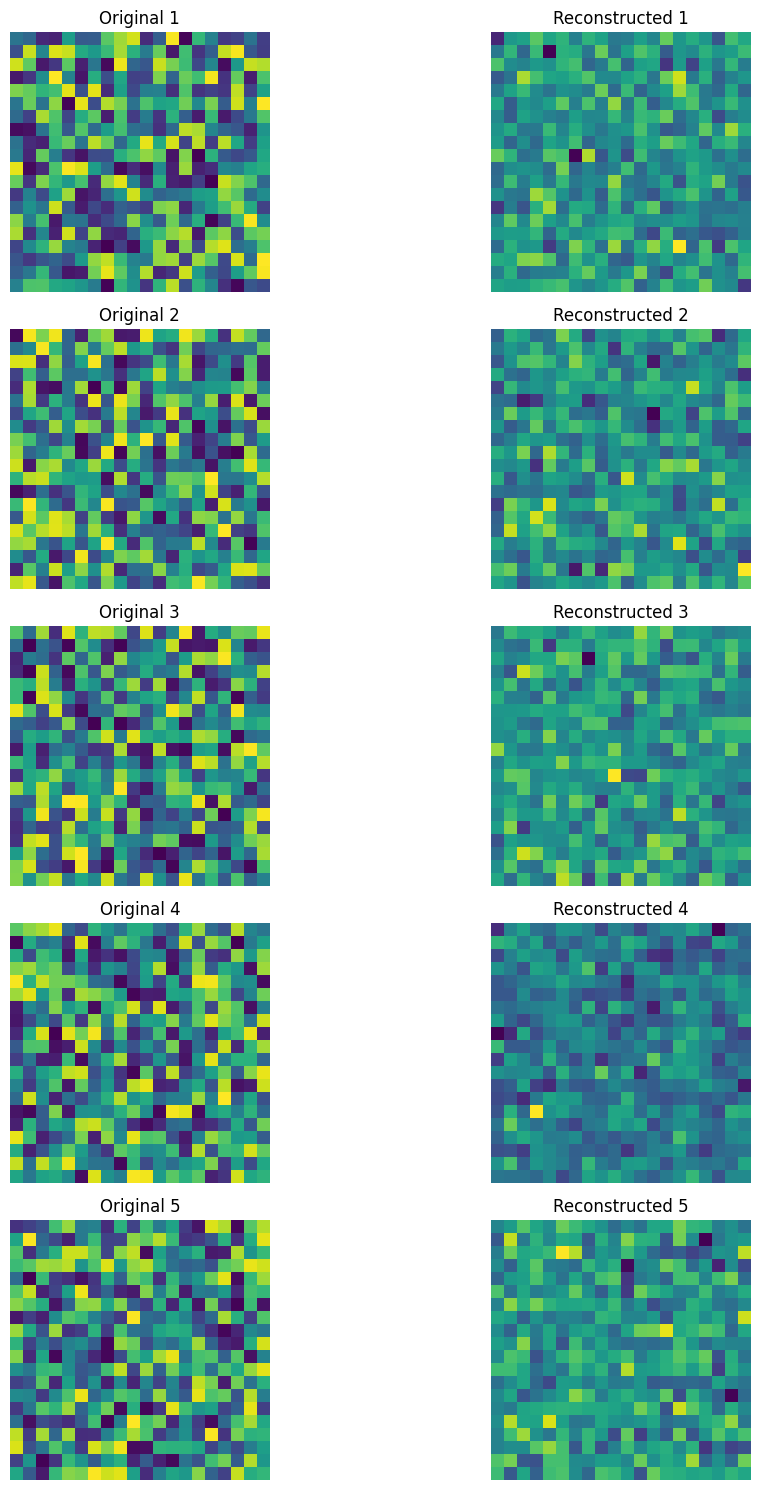

Generating novel structures...


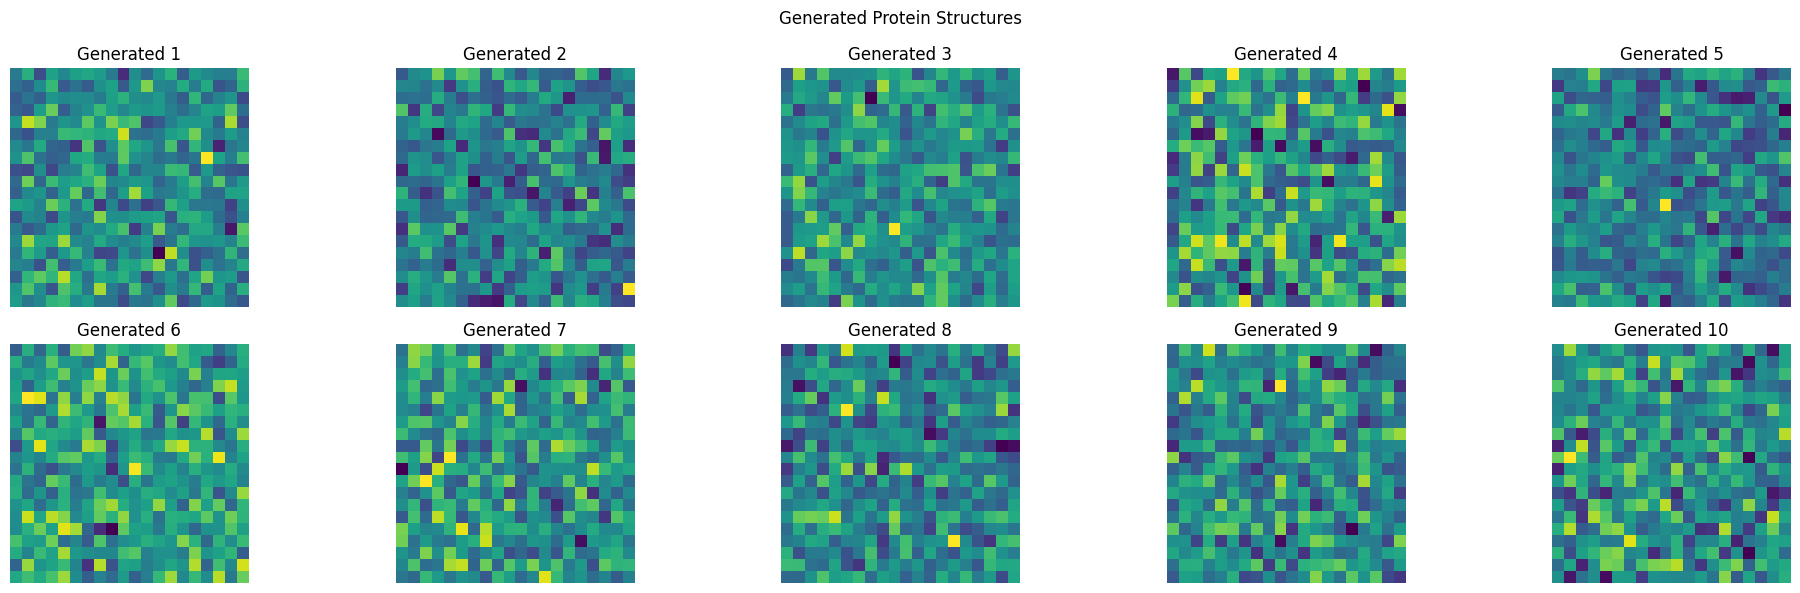

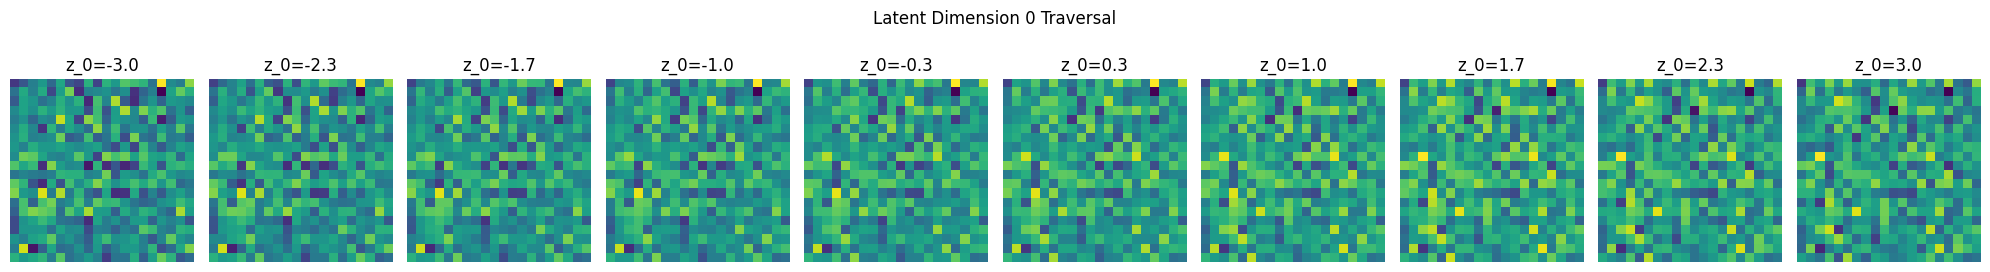

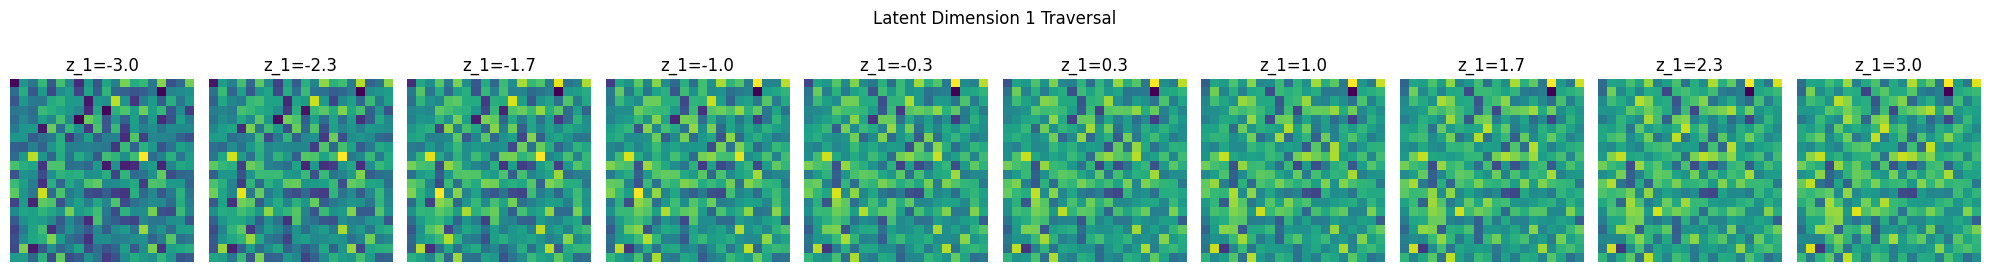

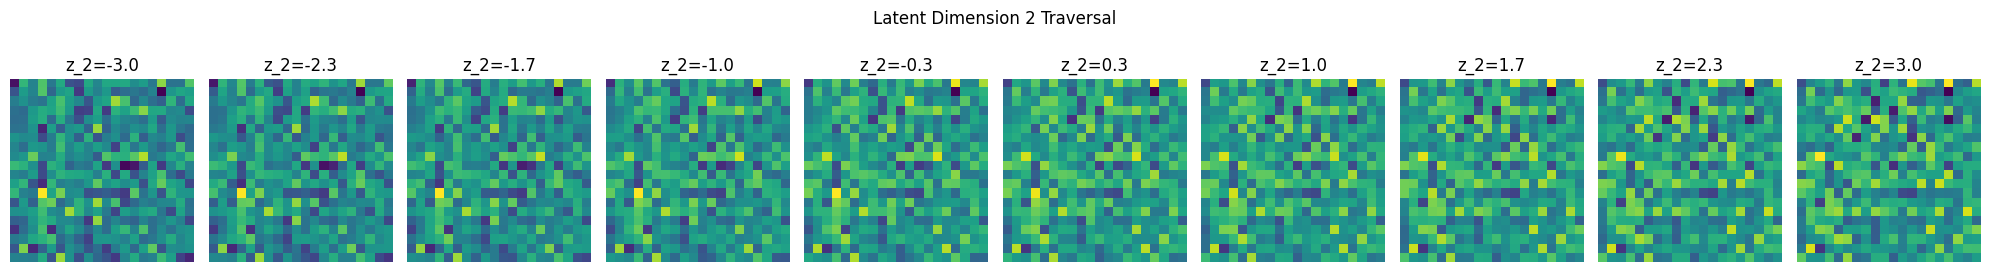

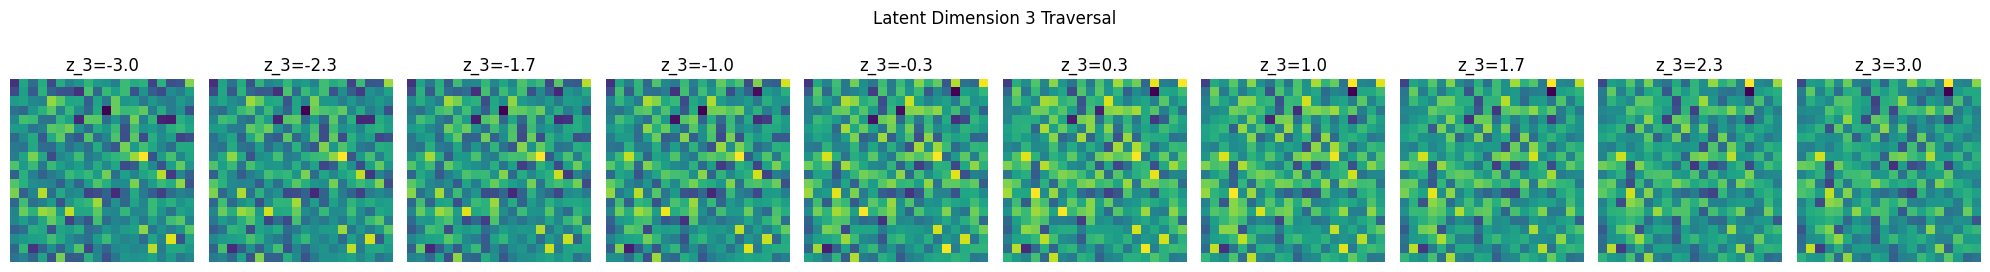

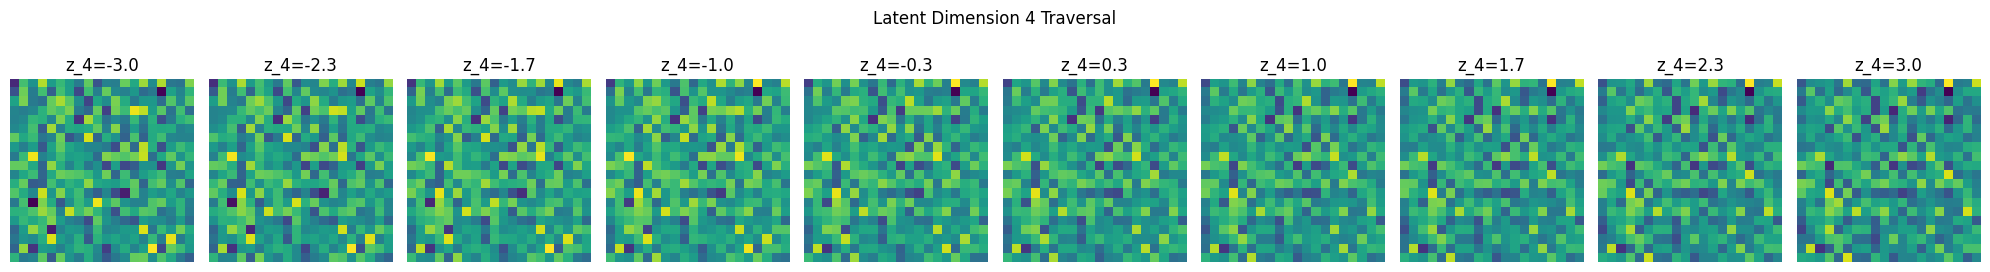

Generating interpolation...


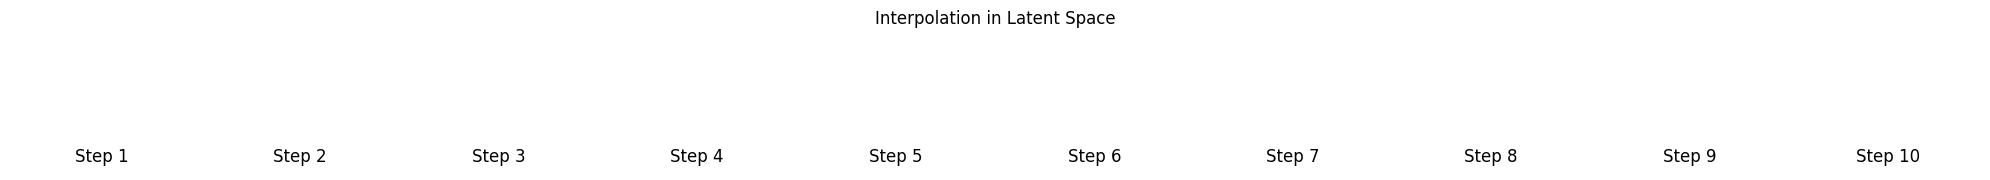

Evaluation and visualization complete!


In [61]:
input_dim = 400  
hidden_dim = 256
latent_dim = 32
batch_size = 128

data_path = '/kaggle/working/protein_data'
os.makedirs(data_path, exist_ok=True)
os.makedirs(os.path.join(data_path, 'train'), exist_ok=True)
os.makedirs(os.path.join(data_path, 'val'), exist_ok=True)
os.makedirs(os.path.join(data_path, 'test'), exist_ok=True)

create_synthetic_dataset(os.path.join(data_path, 'train'), num_samples=1000, input_dim=input_dim)
create_synthetic_dataset(os.path.join(data_path, 'val'), num_samples=200, input_dim=input_dim)
create_synthetic_dataset(os.path.join(data_path, 'test'), num_samples=200, input_dim=input_dim)

train_loader = create_data_loaders(os.path.join(data_path, 'train'), batch_size=batch_size)
val_loader = create_data_loaders(os.path.join(data_path, 'val'), batch_size=batch_size)
test_loader = create_data_loaders(os.path.join(data_path, 'test'), batch_size=batch_size)

model = get_model(input_dim, hidden_dim, latent_dim)

print("Starting training...")
trained_model, train_losses, val_losses = train_model(
    model, 
    train_loader, 
    val_loader, 
    device, 
    epochs=10,  
    lr=3e-4,
    use_amp=True
)

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('loss_curves.png', dpi=300, bbox_inches='tight')
plt.show()

inference_engine = ProteinVAEInferenceEngine(trained_model, device, use_amp=True)

print("Evaluating model...")
metrics, all_mu, all_log_var = evaluate_model(trained_model, test_loader, device, use_amp=True)

print("\nEvaluation Metrics:")
for key, value in metrics.items():
    if isinstance(value, (int, float)):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: shape {np.array(value).shape}")

disentanglement_score, corr_matrix = calculate_disentanglement_score(all_mu)
print(f"Disentanglement score: {disentanglement_score:.4f}")

print("Visualizing latent space...")
reduced_data_2d = plot_latent_space(all_mu, method='tsne')
plot_latent_space(all_mu, method='pca')

plot_latent_heatmap(all_mu, all_log_var)

plot_correlation_matrix(all_mu)

for test_batch in test_loader:
    original_data = test_batch.cpu().numpy()
    break

reconstructed_data = inference_engine.reconstruct(test_batch)

plot_reconstructions(original_data, reconstructed_data, n_samples=5)

print("Generating novel structures...")
novel_structures = inference_engine.generate_novel_structures(n_samples=10, latent_dim=latent_dim)
plot_generated_structures(novel_structures)

base_z, _, _ = inference_engine.encode(test_batch[0])

for dim in range(min(5, latent_dim)):
    plot_latent_traversal(inference_engine, base_z, dim, range_vals=(-3, 3), steps=10)

print("Generating interpolation...")
interpolated = inference_engine.interpolate(test_batch[0], test_batch[1], steps=10)
plot_interpolation(interpolated, steps=10)

torch.save({
    'model_state_dict': trained_model.state_dict(),
    'metrics': metrics,
    'latent_means': all_mu,
    'latent_log_vars': all_log_var
}, 'vae_results.pt')

print("Evaluation and visualization complete!")